In [1]:
import torch
import torch.nn as nn
from dataloaders import load_cifar10
from trainer import Trainer, compute_loss_and_accuracy
from task2 import create_plots
import utils

In [2]:
class ImprovedModel(nn.Module):
    def __init__(self, image_channels, num_classes):
        """
        Is called when model is initialized.
        Args: 
            image_channels. Number of color channels in image (3)
            num_classes: Number of classes we want to predict (10)
        """
        super().__init__()
        
        num_filters = 64  # Set number of filters in first conv layer
        kernel_size = 5
        self.num_classes = num_classes
        
        # Define the convolutional layers
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(
                in_channels=image_channels,
                out_channels=num_filters,
                kernel_size=kernel_size,
                stride=1,
                padding=2,
            ),
            nn.PReLU(),
            nn.BatchNorm2d(num_filters),
            nn.Conv2d(
                in_channels=num_filters,
                out_channels=num_filters,
                kernel_size=kernel_size,
                stride=1,
                padding=2,
            ),
            nn.PReLU(),
            nn.BatchNorm2d(num_filters),
            nn.MaxPool2d(kernel_size=2, 
                         stride=2,
                         padding=0),
            
            nn.Dropout(p=0.2),
            
            nn.Conv2d(
                in_channels=num_filters,
                out_channels=num_filters * 2,
                kernel_size=kernel_size,
                stride=1,
                padding=2,
            ),
            nn.PReLU(),
            nn.BatchNorm2d(num_filters * 2),
            nn.Conv2d(
                in_channels=num_filters * 2,
                out_channels=num_filters * 2,
                kernel_size=kernel_size,
                stride=1,
                padding=2,
            ),
            nn.PReLU(),
            nn.BatchNorm2d(num_filters * 2),
            nn.MaxPool2d(kernel_size=2, 
                         stride=2,
                         padding=0),
            
            nn.Dropout(p=0.2),
            
            nn.Conv2d(
                in_channels=num_filters * 2,
                out_channels=num_filters * 4,
                kernel_size=kernel_size,
                stride=1,
                padding=2,
            ),
            nn.PReLU(),
            nn.BatchNorm2d(num_filters * 4),
            nn.Conv2d(
                in_channels=num_filters * 4,
                out_channels=num_filters * 4,
                kernel_size=kernel_size,
                stride=1,
                padding=2,
            ),
            nn.PReLU(),
            nn.BatchNorm2d(num_filters * 4),
            nn.MaxPool2d(kernel_size=2, 
                         stride=2,
                         padding=0),
            
            nn.Dropout(p=0.1),
            
            nn.Flatten()
            )
        
        self.num_output_features = num_filters * 4 * 4 * 4

        self.classifier = nn.Sequential(
            nn.Linear(self.num_output_features, 64),
            nn.PReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        """
        Performs a forward pass through the model
        Args:
            x: Input image, shape: [batch_size, 3, 32, 32]
        """
        features = self.feature_extractor(x)
                
        preds = self.classifier(features)

        batch_size = preds.shape[0]
        out = preds
        expected_shape = (batch_size, self.num_classes)
        assert out.shape == (
            batch_size,
            self.num_classes,
        ), f"Expected output of forward pass to be: {expected_shape}, but got: {out.shape}"
        return out

In [3]:
epochs = 10
batch_size = 64
learning_rate = 1e-2 # Should be 5e-5 for LeNet
early_stop_count = 4
dataloaders = load_cifar10(batch_size, augment=True)
model = ImprovedModel(image_channels=3, num_classes=10)

print(f"Using device: {utils.get_device()}")
dataloader_types = ["train", "val", "test"]

for i, data in enumerate(dataloaders):
    print(f"{dataloader_types[i]} size: {len(data)}")

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Using device: cuda
train size: 1406
val size: 79
test size: 157


In [4]:
trainer = Trainer(
    batch_size,
    learning_rate,
    early_stop_count,
    epochs,
    model,
    dataloaders,
    Adam=True
)
trainer.train()

ImprovedModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): PReLU(num_parameters=1)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): PReLU(num_parameters=1)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (9): PReLU(num_parameters=1)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (12): PReLU(num_parameters=1)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): MaxPool2d(kernel_size

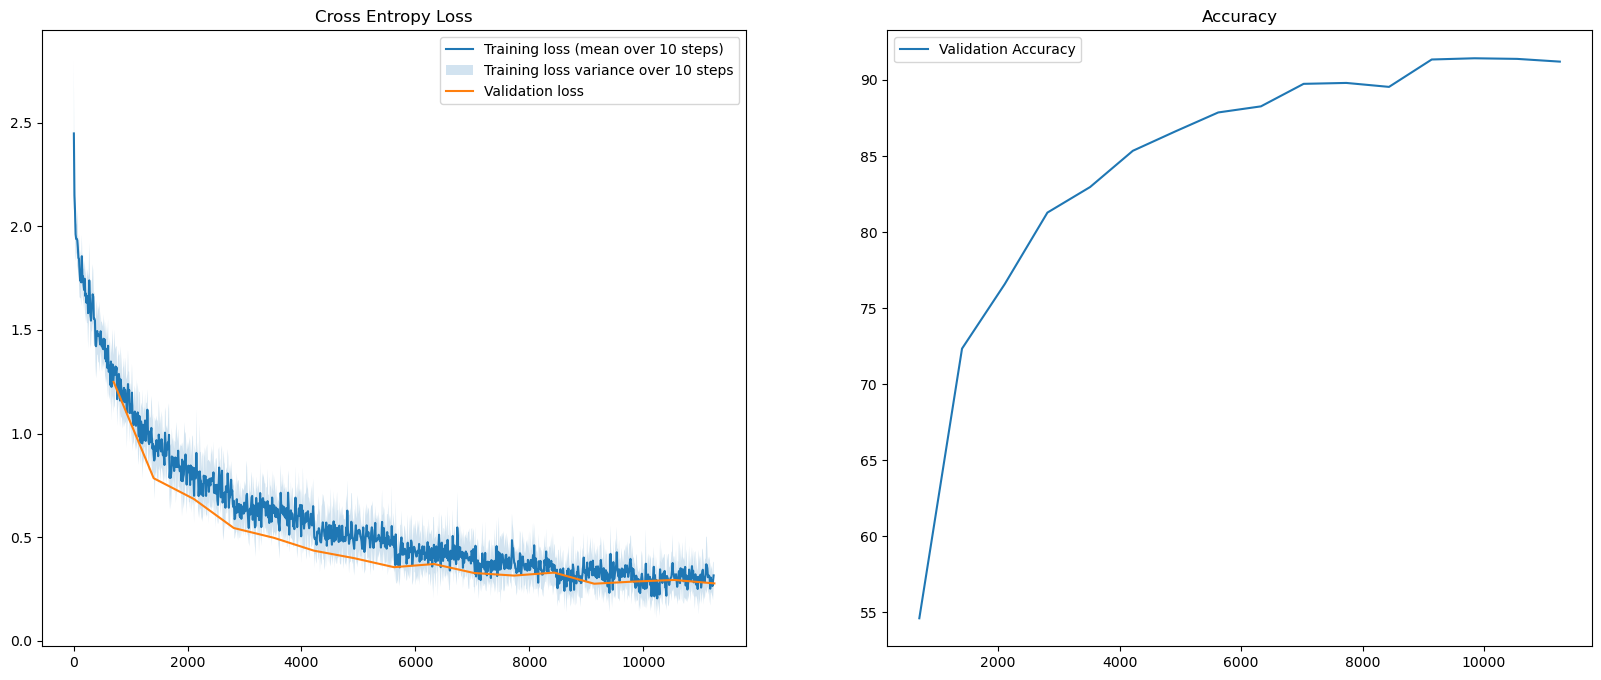

In [5]:
create_plots(trainer, "task3_80")

In [6]:
trainer.load_best_model()
train, val, test = dataloaders

In [7]:
_, train_accuracy = compute_loss_and_accuracy(train, trainer.model, nn.CrossEntropyLoss())
print(f"Training Accuracy: {train_accuracy}")

Training Accuracy: 90.08823790896159


In [8]:
_, val_accuracy = compute_loss_and_accuracy(val, trainer.model, nn.CrossEntropyLoss())
print(f"Validation Accuracy: {val_accuracy}")

Validation Accuracy: 89.24


In [9]:
_, test_accuracy = compute_loss_and_accuracy(test, trainer.model, nn.CrossEntropyLoss())
print(f"Testing Accuracy: {test_accuracy}")

Testing Accuracy: 84.18
